# <center>⭐ Config ⭐</center>

In [1]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [2]:
import torch
import torch.nn as nn
import albumentations as A
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.cuda.amp import GradScaler, autocast

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import sys
import cv2

from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_data_path = '/kaggle/input/contrail-data-torch/train'
train_label_path = '/kaggle/input/contrail-data-torch/train_labels'

val_data_path = '/kaggle/input/contrail-data-torch/val'
val_label_path = '/kaggle/input/contrail-data-torch/val_labels'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()

In [5]:
def visualize(**images):
    plt.figure(figsize=(18, 6))
    
    ax = plt.subplot(1, 3, 1)
    ax.imshow(images['image'])
    ax.set_title('False color image')
    
    ax = plt.subplot(1, 3, 2)
    ax.imshow(images['mask'])
    ax.set_title('Ground truth contrail mask')
        
    ax = plt.subplot(1, 3, 3)
    ax.imshow(images['image'])
    ax.imshow(images['mask'], cmap='Reds', alpha=.4, interpolation='none')
    
    plt.show();
    
def one_hot_encode(label, label_values):
    semantic_map = []
    
    for color in label_values:
        equality = np.equal(label, color)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
        
    semantic_map = np.stack(semantic_map, axis=-1)
    
    return semantic_map

def reverse_one_hot(image):
    x = np.argmax(image, axis=-1)
    return x

def color_codr_segmentation(image, label_values):
    color_codes = np.array(label_values)
    x = color_codes[image.astype(int)]
    
    return x

# <center>⭐ DataAugmentation & DataSet ⭐</center>

In [6]:
# A_transform = [
#     A.OneOf([
#         A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), p=1),# 밝기와 대비 변경
#         A.RandomBrightnessContrast(brightness_limit=(-0.8, 0.8), contrast_limit=0, p=1), # 밝기만 변경
#         A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(-0.8, 0.8), p=1), # 대비만 변경
        
#         # 색상 채도 명도 변경. default(hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20))
#         A.HueSaturationValue(p=1),
#         # RGB 값을 각각 범위내 임의로 변경 default(r_shift_limit=(-20, 20), g_shift_limit=(-20, 20), b_shift_limit=(-20, 20))
#         A.RGBShift(p=1),
#         # RGB Channel을 랜덤하게 섞음
#         A.ChannelShuffle(p=1),
        
#         # 가우시안 노이즈 분포를 가지는 노이즈를 추가
#         A.GaussNoise(p=1, var_limit=(100, 200)),
#         # 정사각형 노이즈 추가
#         A.Cutout(p=1, num_holes=8, max_h_size=24, max_w_size=24),
        
#         # 히스토그램 균일화 기법인 CLAHE를 이용하여 보다 선명한 이미지 발생
#         A.CLAHE(p=1),
#         # blur_limit가 클수록 더 흐림
#         A.Blur(p=1, blur_limit=(50, 60)),
#     ])
# ]

In [7]:
def get_training_augmentation():
    train_transform = A.Compose([
        # A.Resize(384, 384, interpolation=cv2.INTER_CUBIC),
        # A.ChannelShuffle(p=0.5),
#         A.HueSaturationValue(p=0.5, hue_shift_limit=(0, 20), sat_shift_limit=(0, 30), val_shift_limit=(0, 20)),
#         A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), p=0.5),
#         A.GaussNoise(p=1, var_limit=(50, 100)),
#         A.OneOf([
#             A.Sharpen(p=0.5),
#             A.CLAHE(p=0.5),
#             A.Emboss(p=1),
#         ]),
        A.OneOf(
            [
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=1),
                A.RandomRotate90(p=1),
            ],p=0.5),
  
        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
    ])
    
    return train_transform

def get_val_augmentation():   
    test_transform = [
        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        # A.Resize(384, 384, interpolation=cv2.INTER_CUBIC)
    ]
    return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1)

def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(A.Lambda(image=preprocessing_fn))
    _transform.append(A.Lambda(image=to_tensor, mask=to_tensor))
        
    return A.Compose(_transform)

In [8]:
class ContrailDataset(Dataset):
    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        super().__init__()
        self.image_path = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_path = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __len__(self):
        return len(self.image_path)
        
    def __getitem__(self, idx):
        image = np.load(self.image_path[idx])
        mask = np.load(self.mask_path[idx])
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.preprocessing:
            image = np.transpose(image, (2, 0, 1))
            mask = np.transpose(mask, (2, 0, 1))
#             sample = self.preprocessing(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
            
        image = image.astype(np.float32)
        # image = (image - image.min()) / (image.max() - image.min())
        # image /= 255.0
        mask = mask.astype(np.float32)
            
        return image, mask

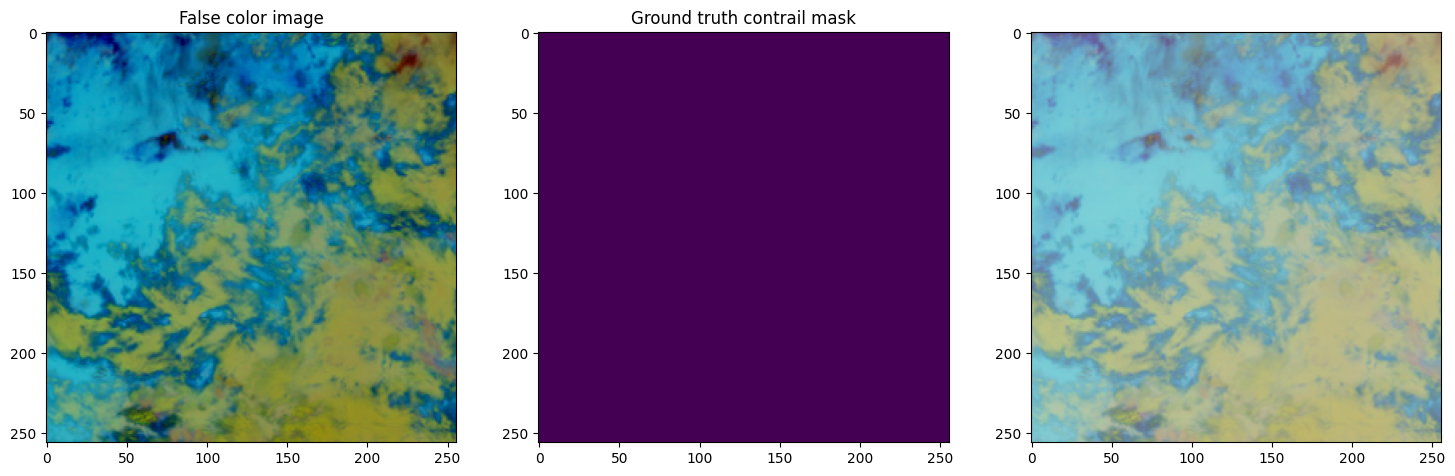

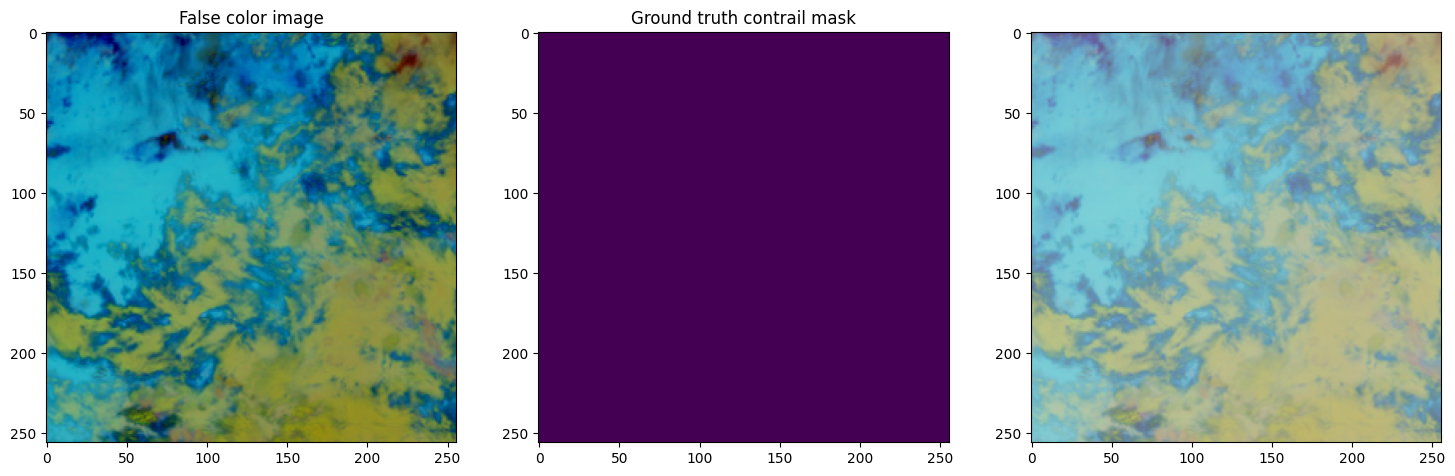

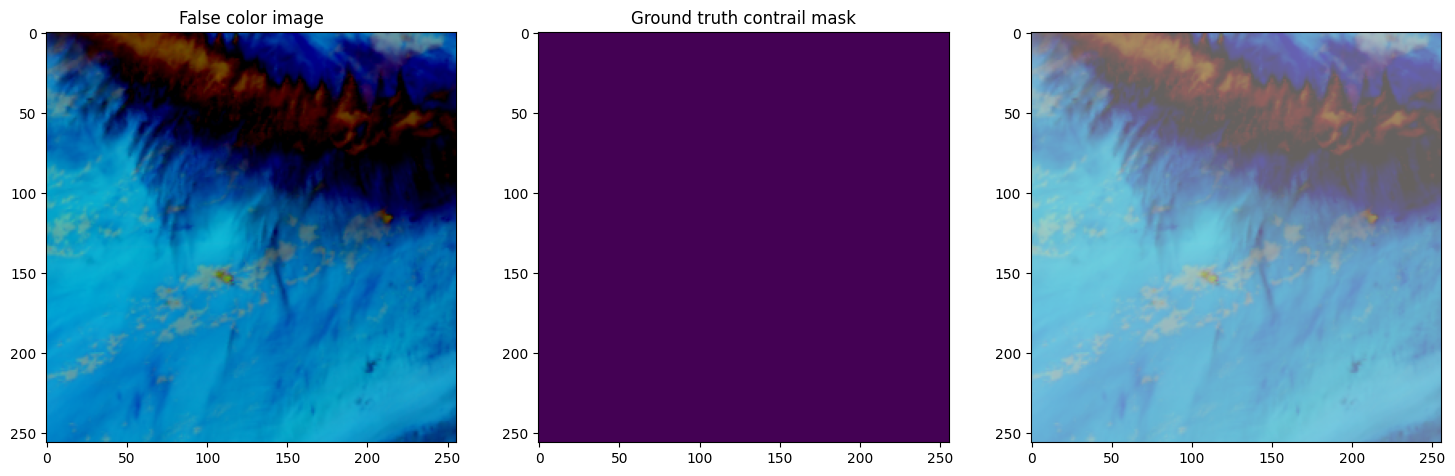

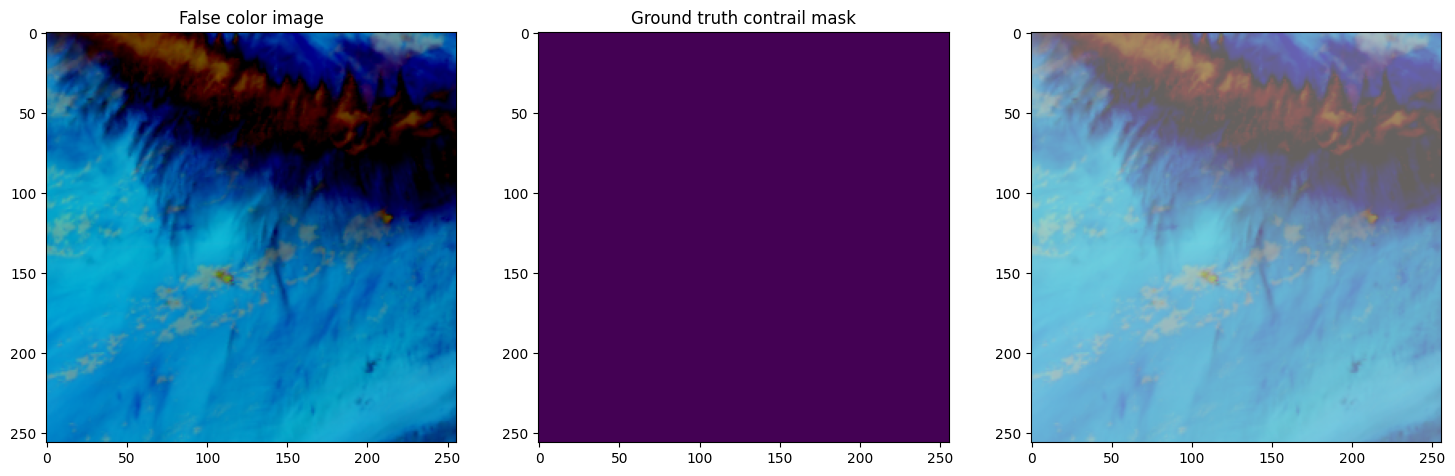

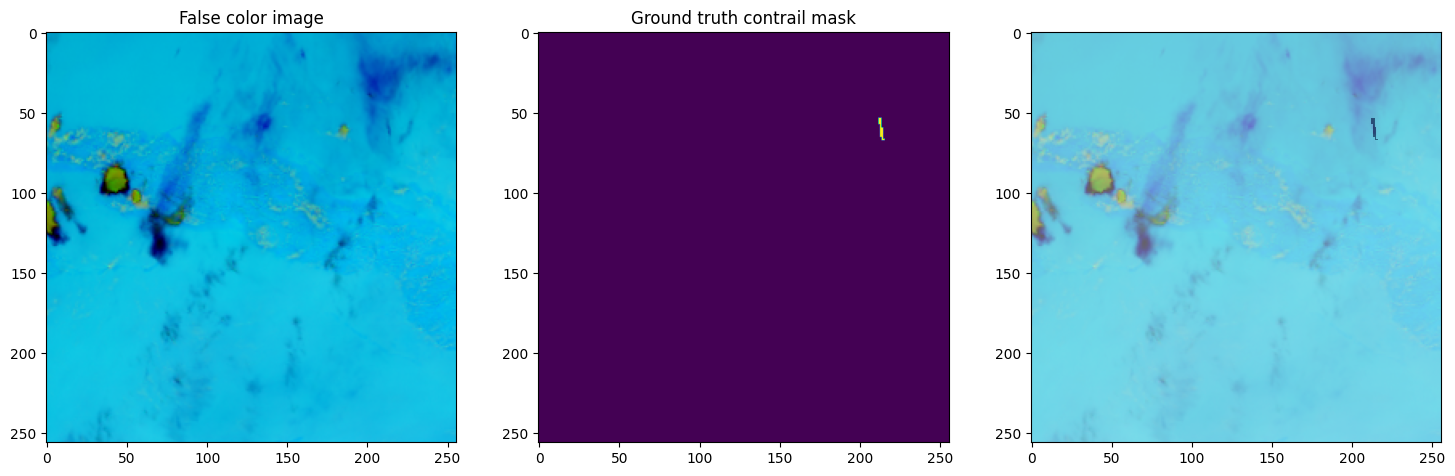

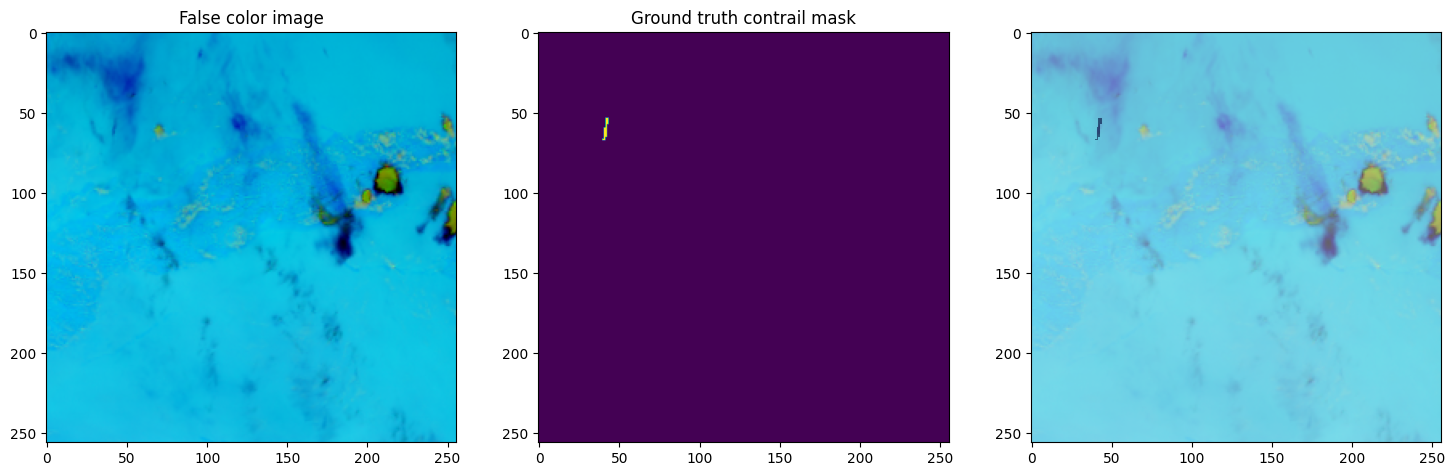

In [9]:
for i in range(3):
    prac_train = ContrailDataset(val_data_path, val_label_path)
    random_idx = random.randint(0, len(prac_train) - 1)
    # image, mask = prac_train[random_idx]
    image, mask = prac_train[i]

    visualize(
        image=image,
        mask=mask
    )

    train_ds = ContrailDataset(val_data_path, val_label_path, get_training_augmentation())
    # image, mask = train_ds[random_idx]
    image, mask = train_ds[i]

    visualize(
        image=image,
        mask=mask
    )

# <center>⭐ Model Config & Model ⭐</center>

In [10]:
class Meter(object):
    def reset(self):
        pass

    def add(self, value):
        pass

    def value(self):
        pass

class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [11]:
class Epoch:
    def __init__(self, model, loss, metrics, stage_name, device="cpu", verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ["{} - {:.4}".format(k, v) for k, v in logs.items()]
        s = ", ".join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):
        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(
            dataloader,
            desc=self.stage_name,
            file=sys.stdout,
            disable=not (self.verbose),
        ) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)
        return logs

class TrainEpoch(Epoch):
    def __init__(self, model, loss, metrics, optimizer, scheduler, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="train",
            device=device,
            verbose=verbose,
        )
        self.scaler = GradScaler()
        self.optimizer = optimizer
        self.scheduler = scheduler

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        with autocast(): # amp
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
            bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(prediction, y)
            loss = loss + bce_loss
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.scheduler.step()
        
        return loss, prediction

class ValidEpoch(Epoch):
    def __init__(self, model, loss, metrics, device="cpu", verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name="valid",
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [12]:
import segmentation_models_pytorch.utils.metrics
import segmentation_models_pytorch.utils

# ENCODER = 'resnet50'
ENCODER = 'efficientnet-b1'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['Contrail']
ACTIVATION = 'sigmoid'

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes = len(CLASSES),
    activation = ACTIVATION,
)

# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

batch_size = 64
steps_per_epoch = int(len(os.listdir(train_data_path)) / batch_size) + 1
TRAINING = True
Epochs = 100
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optim = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=0.01, epochs=Epochs, steps_per_epoch=steps_per_epoch)

# model = torch.load('/kaggle/input/contrail-best-model-saved/EffNet_b0_BCE_0.01_Add_Zero.pth', map_location=DEVICE)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:01<00:00, 30.2MB/s]


In [13]:
train_ds = ContrailDataset(train_data_path, train_label_path, get_training_augmentation(), preprocessing=True)
val_ds = ContrailDataset(val_data_path, val_label_path, get_val_augmentation(), preprocessing=True)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [14]:
train_epoch = TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optim,
    scheduler = scheduler,
    device=DEVICE,
    verbose=True
)

val_epoch = ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True
)

# <center>⭐ Train & Val ⭐</center>

In [15]:
if TRAINING:
    
    best_iou_score = 0.0
    train_logs_list, val_logs_list = [], []
    
    for i in tqdm(range(0, Epochs)):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_dl)
        val_logs = val_epoch.run(val_dl)
        print(train_logs)
        print(val_logs)
        train_logs_list.append(train_logs)
        val_logs_list.append(val_logs)
        
        if best_iou_score < val_logs['iou_score']:
            best_iou_score = val_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model Saved!')

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 0


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.3751436167416913, 'iou_score': 0.2516712683754916}
{'dice_loss': 0.6290244049039383, 'iou_score': 0.2526377809458765}
Model Saved!

Epoch: 1


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.1423376252718074, 'iou_score': 0.38903673053530535}
{'dice_loss': 0.49460700462604396, 'iou_score': 0.3495956505167073}
Model Saved!

Epoch: 2


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.1168378866350175, 'iou_score': 0.4096810213316267}
{'dice_loss': 0.48883393715167867, 'iou_score': 0.35062705391439897}
Model Saved!

Epoch: 3


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.107458208208886, 'iou_score': 0.41747727915876737}
{'dice_loss': 0.46626522623259437, 'iou_score': 0.37054345474160943}
Model Saved!

Epoch: 4


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0995045855780625, 'iou_score': 0.4247863677988916}
{'dice_loss': 0.4715321598381832, 'iou_score': 0.3648493957930598}

Epoch: 5


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0987647326193122, 'iou_score': 0.42530801734448986}
{'dice_loss': 0.4764645222959847, 'iou_score': 0.3584686548545443}

Epoch: 6


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0959472589403667, 'iou_score': 0.4276476215536349}
{'dice_loss': 0.5044005657064504, 'iou_score': 0.3338802354089145}

Epoch: 7


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0966305758722843, 'iou_score': 0.42671603920675155}
{'dice_loss': 0.4663385974949804, 'iou_score': 0.36779205141396365}

Epoch: 8


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0952994622916827, 'iou_score': 0.4280056569992199}
{'dice_loss': 0.7220771990973376, 'iou_score': 0.17063412410688814}

Epoch: 9


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0950358842392203, 'iou_score': 0.42810687459889263}
{'dice_loss': 0.49733288534756365, 'iou_score': 0.3389202058315276}

Epoch: 10


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0966667594196642, 'iou_score': 0.4263387944468083}
{'dice_loss': 0.4987210096984074, 'iou_score': 0.3378660365425307}

Epoch: 11


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0938299953751844, 'iou_score': 0.4291384306466468}
{'dice_loss': 0.7288977257136642, 'iou_score': 0.15963642633166808}

Epoch: 12


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.098037317163105, 'iou_score': 0.4248564065059768}
{'dice_loss': 0.48185617964843225, 'iou_score': 0.35366087329798734}

Epoch: 13


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0938586977040663, 'iou_score': 0.42907528026824426}
{'dice_loss': 0.47778555853613497, 'iou_score': 0.35624831298301957}

Epoch: 14


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0978102453772527, 'iou_score': 0.42503777294886835}
{'dice_loss': 0.5426654795120501, 'iou_score': 0.29959605274529294}

Epoch: 15


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0930778389779203, 'iou_score': 0.42983809884092156}
{'dice_loss': 0.4931371438092199, 'iou_score': 0.3433157606371517}

Epoch: 16


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0924642271713296, 'iou_score': 0.4302826957353552}
{'dice_loss': 0.4881706052813036, 'iou_score': 0.3473641672011079}

Epoch: 17


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.095154654942569, 'iou_score': 0.42755156031278807}
{'dice_loss': 0.4931347411254357, 'iou_score': 0.34278736494738477}

Epoch: 18


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0935591730373293, 'iou_score': 0.4292602391443522}
{'dice_loss': 0.4814826763909438, 'iou_score': 0.3529582100695577}

Epoch: 19


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0903187607679041, 'iou_score': 0.43248741843990085}
{'dice_loss': 0.494602986450853, 'iou_score': 0.34194698210420277}

Epoch: 20


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.087449213426061, 'iou_score': 0.4353559797983676}
{'dice_loss': 0.5361851207141218, 'iou_score': 0.30475219930040426}

Epoch: 21


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0889670954686455, 'iou_score': 0.43384786437605055}
{'dice_loss': 0.4936215898086284, 'iou_score': 0.34233567067261406}

Epoch: 22


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.087662002379278, 'iou_score': 0.43512950043811965}
{'dice_loss': 0.4959353660715038, 'iou_score': 0.3397522404276092}

Epoch: 23


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0898027501745025, 'iou_score': 0.43289860841641187}
{'dice_loss': 0.499272591081159, 'iou_score': 0.337950927944019}

Epoch: 24


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0823741263689657, 'iou_score': 0.44049684327339417}
{'dice_loss': 0.4672241765877297, 'iou_score': 0.3670268644546641}

Epoch: 25


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.089044260087415, 'iou_score': 0.43385865977991434}
{'dice_loss': 0.5000789103836849, 'iou_score': 0.3362566998292661}

Epoch: 26


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0830401033627293, 'iou_score': 0.4398253173842979}
{'dice_loss': 0.5109015456561385, 'iou_score': 0.32687211036682123}

Epoch: 27


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.083124883821078, 'iou_score': 0.43975505334937304}
{'dice_loss': 0.49748839386578264, 'iou_score': 0.3402343197115536}

Epoch: 28


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.082334805129102, 'iou_score': 0.44055792345807565}
{'dice_loss': 0.47643165547272254, 'iou_score': 0.3579534297359401}

Epoch: 29


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.079242888269395, 'iou_score': 0.4436335108733251}
{'dice_loss': 0.48899074669541986, 'iou_score': 0.34655016917606885}

Epoch: 30


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.077985534786807, 'iou_score': 0.44498407422939135}
{'dice_loss': 0.46097599432386205, 'iou_score': 0.3724470421158034}
Model Saved!

Epoch: 31


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.081390991760563, 'iou_score': 0.44149740527723447}
{'dice_loss': 0.4942979319342251, 'iou_score': 0.3410102195780853}

Epoch: 32


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0771594092110612, 'iou_score': 0.44582759331319927}
{'dice_loss': 0.4469714000307281, 'iou_score': 0.38536181069653613}
Model Saved!

Epoch: 33


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0715074710014079, 'iou_score': 0.45171551086078204}
{'dice_loss': 0.4692226525010733, 'iou_score': 0.3637832069191439}

Epoch: 34


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0718787845421434, 'iou_score': 0.45131165411242086}
{'dice_loss': 0.44272289399443, 'iou_score': 0.38896811111220003}
Model Saved!

Epoch: 35


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0688392937740436, 'iou_score': 0.4544471317548246}
{'dice_loss': 0.46396856883476517, 'iou_score': 0.3689834552592245}

Epoch: 36


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0689167759128821, 'iou_score': 0.45436676872482173}
{'dice_loss': 0.4915816722245053, 'iou_score': 0.343559880708826}

Epoch: 37


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.069848944650632, 'iou_score': 0.45349855335702016}
{'dice_loss': 0.47515959164191945, 'iou_score': 0.35831067582656595}

Epoch: 38


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0679444806226692, 'iou_score': 0.4554242304181015}
{'dice_loss': 0.4460944903307948, 'iou_score': 0.38629749828371507}

Epoch: 39


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.066956307472099, 'iou_score': 0.4564626163039995}
{'dice_loss': 0.4252215007255818, 'iou_score': 0.40527421749871345}
Model Saved!

Epoch: 40


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0642767037929406, 'iou_score': 0.45922121015664563}
{'dice_loss': 0.5030149838020062, 'iou_score': 0.33416820805648284}

Epoch: 41


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0644726556409556, 'iou_score': 0.4591166244303325}
{'dice_loss': 0.5725157671961292, 'iou_score': 0.2765663684955958}

Epoch: 42


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.060828705443029, 'iou_score': 0.4629139558548497}
{'dice_loss': 0.4254784542938758, 'iou_score': 0.4057727908266002}
Model Saved!

Epoch: 43


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0592874294129475, 'iou_score': 0.46456070508912345}
{'dice_loss': 0.43357768140990155, 'iou_score': 0.3976919301624955}

Epoch: 44


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0572402120750652, 'iou_score': 0.46666461080776944}
{'dice_loss': 0.47356584565392856, 'iou_score': 0.35996808111667633}

Epoch: 45


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.057354017767209, 'iou_score': 0.4666058109185404}
{'dice_loss': 0.5236575521271803, 'iou_score': 0.3159740176694146}

Epoch: 46


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0554933800504216, 'iou_score': 0.4686154387078926}
{'dice_loss': 0.46728374423651864, 'iou_score': 0.3655039328953315}

Epoch: 47


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.056236758039004, 'iou_score': 0.46783594355404934}
{'dice_loss': 0.4310770528069859, 'iou_score': 0.40001576573684294}

Epoch: 48


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.054427521993809, 'iou_score': 0.46981324742887653}
{'dice_loss': 0.4979001263092305, 'iou_score': 0.3372669189140714}

Epoch: 49


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0537797374146018, 'iou_score': 0.47044540082925573}
{'dice_loss': 0.5115377718004688, 'iou_score': 0.32586387878861917}

Epoch: 50


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.053035164362174, 'iou_score': 0.47120622441033344}
{'dice_loss': 0.41268147065721705, 'iou_score': 0.4185418620191772}
Model Saved!

Epoch: 51


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0492882269936552, 'iou_score': 0.4752350453275761}
{'dice_loss': 0.41314513313359236, 'iou_score': 0.4173390680345995}

Epoch: 52


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0473436217441727, 'iou_score': 0.4773612043753591}
{'dice_loss': 0.4402708041256872, 'iou_score': 0.3917471478725302}

Epoch: 53


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0466854546300368, 'iou_score': 0.4781125480326537}
{'dice_loss': 0.44851974988805837, 'iou_score': 0.3832091288319949}

Epoch: 54


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0443325150421476, 'iou_score': 0.480665481071977}
{'dice_loss': 0.419170447464647, 'iou_score': 0.41185982576731983}

Epoch: 55


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0407310430877306, 'iou_score': 0.484642750934648}
{'dice_loss': 0.4432441263363279, 'iou_score': 0.3891267699414286}

Epoch: 56


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0439539718850754, 'iou_score': 0.4810925827962218}
{'dice_loss': 0.43782288658207846, 'iou_score': 0.39363987384171323}

Epoch: 57


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0421261336201821, 'iou_score': 0.4830714115101229}
{'dice_loss': 0.4521418419377557, 'iou_score': 0.3816729357530332}

Epoch: 58


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0396838334861942, 'iou_score': 0.48580200742709706}
{'dice_loss': 0.4159649713286038, 'iou_score': 0.4160505558910041}

Epoch: 59


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0372496174874712, 'iou_score': 0.4883989571039553}
{'dice_loss': 0.41197015293713274, 'iou_score': 0.4194685929808123}
Model Saved!

Epoch: 60


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0365964502931746, 'iou_score': 0.4891798038534656}
{'dice_loss': 0.41281812972035903, 'iou_score': 0.4187856707079657}

Epoch: 61


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0331458820732207, 'iou_score': 0.4928633129670985}
{'dice_loss': 0.4042406493219835, 'iou_score': 0.4267498223946012}
Model Saved!

Epoch: 62


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0340457283819195, 'iou_score': 0.49190039835243604}
{'dice_loss': 0.4012174729643197, 'iou_score': 0.4301231380166679}
Model Saved!

Epoch: 63


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0314905832861072, 'iou_score': 0.4947793244201444}
{'dice_loss': 0.39729111975636977, 'iou_score': 0.434325542943231}
Model Saved!

Epoch: 64


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.03098465237662, 'iou_score': 0.4952583953598949}
{'dice_loss': 0.399710213315898, 'iou_score': 0.4323657494166802}

Epoch: 65


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0273590981031875, 'iou_score': 0.4993380694374489}
{'dice_loss': 0.3923453996921407, 'iou_score': 0.4386032038721545}
Model Saved!

Epoch: 66


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0273365571491442, 'iou_score': 0.4993426021757153}
{'dice_loss': 0.4124031066894531, 'iou_score': 0.41924023885151435}

Epoch: 67


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0259566635728983, 'iou_score': 0.500993226176111}
{'dice_loss': 0.3929943154598104, 'iou_score': 0.43832872653829635}

Epoch: 68


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.023455344256582, 'iou_score': 0.5036759941006}
{'dice_loss': 0.39184809347678873, 'iou_score': 0.4393682017408567}
Model Saved!

Epoch: 69


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.021383524869461, 'iou_score': 0.5060669120598439}
{'dice_loss': 0.39583831203394926, 'iou_score': 0.4354812446339377}

Epoch: 70


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0203587563238405, 'iou_score': 0.5071469268694848}
{'dice_loss': 0.3935627505697054, 'iou_score': 0.4370459698397537}

Epoch: 71


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0183506175365034, 'iou_score': 0.5094343170384383}
{'dice_loss': 0.40295149540079056, 'iou_score': 0.4284932716139433}

Epoch: 72


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0172852673263189, 'iou_score': 0.5106142405594627}
{'dice_loss': 0.4044383723160316, 'iou_score': 0.4270683393396181}

Epoch: 73


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0179940384125048, 'iou_score': 0.509926117283533}
{'dice_loss': 0.3899994883044013, 'iou_score': 0.44097053285302784}
Model Saved!

Epoch: 74


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0151535781373118, 'iou_score': 0.5131037329958973}
{'dice_loss': 0.4029502560352458, 'iou_score': 0.42825627224198703}

Epoch: 75


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0146584471809539, 'iou_score': 0.5136552331417891}
{'dice_loss': 0.38630218341432765, 'iou_score': 0.4444014717792643}
Model Saved!

Epoch: 76


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0144546329046709, 'iou_score': 0.5139609880722199}
{'dice_loss': 0.39883775341099714, 'iou_score': 0.4324388807189875}

Epoch: 77


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0124301553886614, 'iou_score': 0.5162464081312633}
{'dice_loss': 0.3939641282476228, 'iou_score': 0.4374474276756418}

Epoch: 78


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0094360224554466, 'iou_score': 0.5195965520875101}
{'dice_loss': 0.3937961767459738, 'iou_score': 0.43766194633368793}

Epoch: 79


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0079842711163443, 'iou_score': 0.5213906179150314}
{'dice_loss': 0.3892107009887695, 'iou_score': 0.4421132587153337}

Epoch: 80


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.007781619223478, 'iou_score': 0.5215600201645374}
{'dice_loss': 0.38178915813051423, 'iou_score': 0.44933624925284543}
Model Saved!

Epoch: 81


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0079373969838628, 'iou_score': 0.5213775994993074}
{'dice_loss': 0.37905556785649264, 'iou_score': 0.45213881854353277}
Model Saved!

Epoch: 82


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.006672845265576, 'iou_score': 0.522708315808454}
{'dice_loss': 0.3829027496535202, 'iou_score': 0.4481361909159298}

Epoch: 83


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0053195908804942, 'iou_score': 0.524309917680942}
{'dice_loss': 0.38630121124201805, 'iou_score': 0.4451272888430233}

Epoch: 84


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0031519385513115, 'iou_score': 0.5269638280445175}
{'dice_loss': 0.3880768274438793, 'iou_score': 0.4430919608165477}

Epoch: 85


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0026552285360764, 'iou_score': 0.527371823880531}
{'dice_loss': 0.38618745269446536, 'iou_score': 0.44501707985483363}

Epoch: 86


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.001973358455848, 'iou_score': 0.528275509861028}
{'dice_loss': 0.3789009821826014, 'iou_score': 0.45235967841641656}
Model Saved!

Epoch: 87


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0011221164854887, 'iou_score': 0.5292553139438507}
{'dice_loss': 0.3852315791722002, 'iou_score': 0.44607654933271734}

Epoch: 88


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0011125186522065, 'iou_score': 0.5292519327264706}
{'dice_loss': 0.38227290120618096, 'iou_score': 0.44904837731657365}

Epoch: 89


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0009798986889498, 'iou_score': 0.5293609165699679}
{'dice_loss': 0.38082385268704644, 'iou_score': 0.4504088708038987}

Epoch: 90


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 1.0001070401007515, 'iou_score': 0.5304527407123296}
{'dice_loss': 0.38127601146698004, 'iou_score': 0.4499376118183137}

Epoch: 91


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 0.9998088330494651, 'iou_score': 0.5307619517837354}
{'dice_loss': 0.38196239800288767, 'iou_score': 0.44922427267863835}

Epoch: 92


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 0.9985639250538432, 'iou_score': 0.5320954130631738}
{'dice_loss': 0.38308695678053234, 'iou_score': 0.4482411166717266}

Epoch: 93


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 0.9990582035338026, 'iou_score': 0.531680042312896}
{'dice_loss': 0.3820800308523507, 'iou_score': 0.4491722121320922}

Epoch: 94


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 0.9977171395055232, 'iou_score': 0.5331883405413587}
{'dice_loss': 0.38191867080228087, 'iou_score': 0.4493898009431774}

Epoch: 95


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 0.9973884640824391, 'iou_score': 0.5335837825436464}
{'dice_loss': 0.3825146555900573, 'iou_score': 0.4486421274727789}

Epoch: 96


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 0.9968756281326863, 'iou_score': 0.5341573870070632}
{'dice_loss': 0.3819309000311227, 'iou_score': 0.4493125759322067}

Epoch: 97


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 0.9981371452132491, 'iou_score': 0.5327210268498951}
{'dice_loss': 0.381609398743202, 'iou_score': 0.44958807887702157}

Epoch: 98


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 0.9988750098650327, 'iou_score': 0.5318781605390746}
{'dice_loss': 0.3812374225978194, 'iou_score': 0.44990665028835164}

Epoch: 99


train:   0%|          | 0/321 [00:00<?, ?it/s]

valid:   0%|          | 0/29 [00:00<?, ?it/s]

{'dice_loss': 0.9979060956993585, 'iou_score': 0.5329643596555583}
{'dice_loss': 0.38147390094296696, 'iou_score': 0.44966097844058067}
